In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)

In [70]:
time = 0

Rearth = 6371*1000

dt = 0.1   #timestep

tvert = 20  #assuming 20 seconds of vertical flight

T01 = 6*2200*1000+3*2200*1000
T02 = 3*2200*1000
T03 = 2200*1000
TLanding = 10

tbo1 = 205.13-TLanding #In this case all 3 boosters fire at 100% for 195.13 seconds
tbo2 = 184.6-TLanding  #In this case this is the upper stage
tbo3 = 0               #Isnt used in this one

m01 = 3*420*1000+126*1000+21*1000+1000
m02 = 126*1000+21*1000
m03 = 0

mdot1 = 9*650
mdot2 = 650
mdot3 = 0

total_flight_time = tbo1 + tbo2 + tbo3

gravity_turn_kick = 86
gtk = gravity_turn_kick
theta_fix = np.deg2rad(30)

launch_location_boost = 463

Maximum Altitude of payload and secondary booster = 305506.227567829 m
Total DeltaV of Rocket =  9784.2911467922 m/s


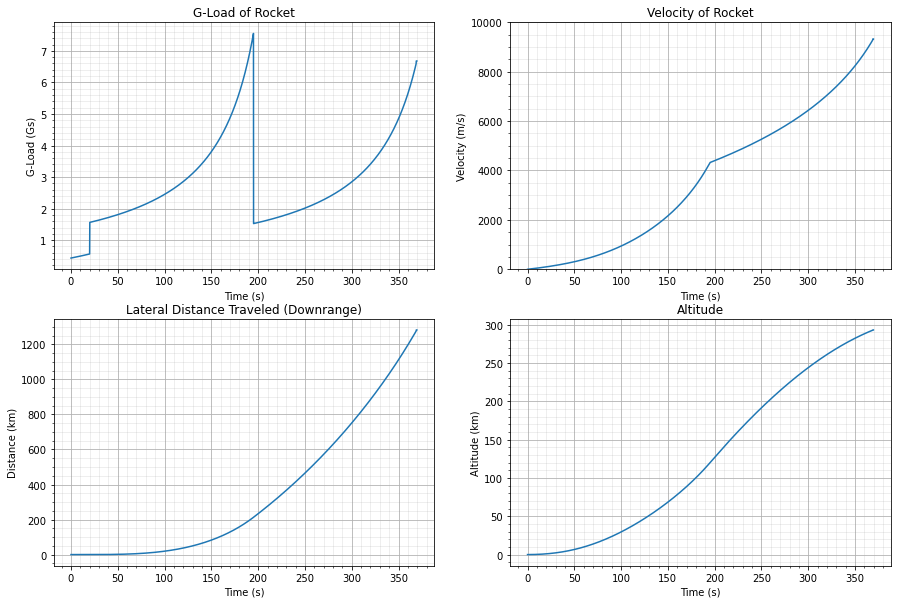

In [104]:
## Initial Matrices

ti_v = tvert/dt;           #vertical flight time interval
ti = total_flight_time/dt  #total time interval
acc = np.zeros((int(ti)))
g_load = np.zeros((int(ti)))
time = np.zeros((int(ti)))
velx = np.zeros((int(ti)))
velz = np.zeros((int(ti)))
vel = np.zeros((int(ti)))
xpos = np.zeros((int(ti)))
zpos = np.zeros((int(ti)))
gamma = np.zeros((int(ti)))


## Initial Conditions

time[0] = 0
velx[0] = 0.0
velz[0] = 0.0
vel[0] = 0.0

xpos[0] = 0.0
zpos[0] = 0.0

gamma[0] = np.deg2rad(90) # initial vertical flight (radians)

## Flight

ti = int(ti)
tvert = int(tvert)

time = np.arange(0,ti)
time01 = time[slice(0,int(20/dt))]
time02 = time[slice(int(20/dt),int(tbo1/dt))]
time03 = time[slice(int(tbo1/dt),int(tbo2/dt)+int(tbo1/dt))]

for k in time01:                                #Vertical Flight
    acc[k] = T01/(m01-mdot1*(time[k]*dt))-9.81
    vel[k] = acc[k]*dt+vel[k-1]
    velz[k] = vel[k]
    
    zpos[k] = zpos[k-1]+velz[k]*dt+0.5*acc[k]*np.sin(gamma[k])*dt*dt
    
    gamma[k+1] = gamma[k]


gamma[tvert*10] = np.deg2rad(gtk)

for k in time02:                                #Rest of First Stage
    
    gl = 9.81*np.sin(gamma[k])
    
    acc[k] = T01/((m01-mdot1*(time[k]*dt)))
    
    vel[k] = (acc[k]-9.81*np.sin(gamma[k]))*dt+vel[k-1]
    velx[k] = vel[k]*np.cos(gamma[k])
    velz[k] = vel[k]*np.sin(gamma[k])
    
    xpos[k] = xpos[k-1]+velx[k]*dt+0.5*acc[k]*np.cos(gamma[k])*dt*dt
    zpos[k] = zpos[k-1]+velz[k]*dt+0.5*acc[k]*np.sin(gamma[k])*dt*dt

    gamma[k+1] = gamma[k]+vel[k]*np.cos(gamma[k])*dt/(Rearth+zpos[k])-9.81*np.cos(gamma[k])*dt/vel[k-1]*0.98
    #0.98 was used to limit the change in flight path angle. In reality this will be done with control surfaces or thrust vectoring
    
#Ignore any gravity losses in the upper stage
for k in time03:                                 #Second Stage
    if gamma[k] > theta_fix:
        #Continues Gravity Turn
        acc[k] = T03/((m02-mdot2*(time[k-int(tbo1)*10]/10)))
        vel[k] = (acc[k])*dt+vel[k-1]
        velx[k] = vel[k]*np.cos(gamma[k])
        velz[k] = vel[k]*np.sin(gamma[k])
        
        xpos[k] = xpos[k-1]+velx[k]*dt+0.5*acc[k]*np.cos(gamma[k])*dt*dt
        zpos[k] = zpos[k-1]+velz[k]*dt+0.5*acc[k]*np.sin(gamma[k])*dt*dt
        #Update Flight Path angle due to centripetal and gravity effect
        gamma[k+1]=gamma[k]+vel[k]*np.cos(gamma[k])*dt/(Rearth+zpos[k])-9.81*np.cos(gamma[k])*dt/(vel[k])-9.81*np.cos(gamma[k])*dt/vel[k]
    else:
        #Fixed Pitch Flight
        acc[k] = T03/((m02-mdot2*(time[k-int(tbo1)*10]/10)))
        vel[k] = (acc[k])*dt+vel[k-1]
        velx[k] = vel[k]*np.cos(gamma[k])
        velz[k] = vel[k]*np.sin(gamma[k])
        
        xpos[k] = xpos[k-1]+velx[k]*dt+0.5*acc[k]*np.cos(gamma[k])*dt*dt
        zpos[k] = zpos[k-1]+velz[k]*dt+0.5*acc[k]*np.sin(gamma[k])*dt*dt
        
        gamma[k+1] = gamma[k]-9.81*np.cos(gamma[k])*dt/(vel[k])


zpos2 = np.max(zpos)+(velz[-2]*velz[-2])/(2*9.81)
print('Maximum Altitude of payload and secondary booster =',zpos2,'m')

for i in range(8):                        #Fixes zero bug at end of arrays
    vel[-1-i]=np.max(vel)
    acc[-1-i]=np.max(acc[slice(2000,ti)])
    xpos[-1-i]=np.max(xpos)
    zpos[-1-i]=np.max(zpos)
    velx[-1-i]=np.max(velx)
    velz[-1-i]=velz[-9]

plt.figure(figsize=[15,10])

plt.subplot(221)
plt.plot(time*dt,acc/9.81)
plt.title('G-Load of Rocket')
plt.xlabel('Time (s)')
plt.ylabel('G-Load (Gs)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.subplot(222)
plt.plot(time*dt,vel)
plt.title('Velocity of Rocket')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.ylim(0,10000)
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.subplot(223)
plt.plot(time*dt,xpos/1000)
plt.title('Lateral Distance Traveled (Downrange)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.subplot(224)
plt.plot(time*dt,zpos/1000)
plt
plt.title('Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

print('Total DeltaV of Rocket = ',np.max(vel)+launch_location_boost,'m/s')

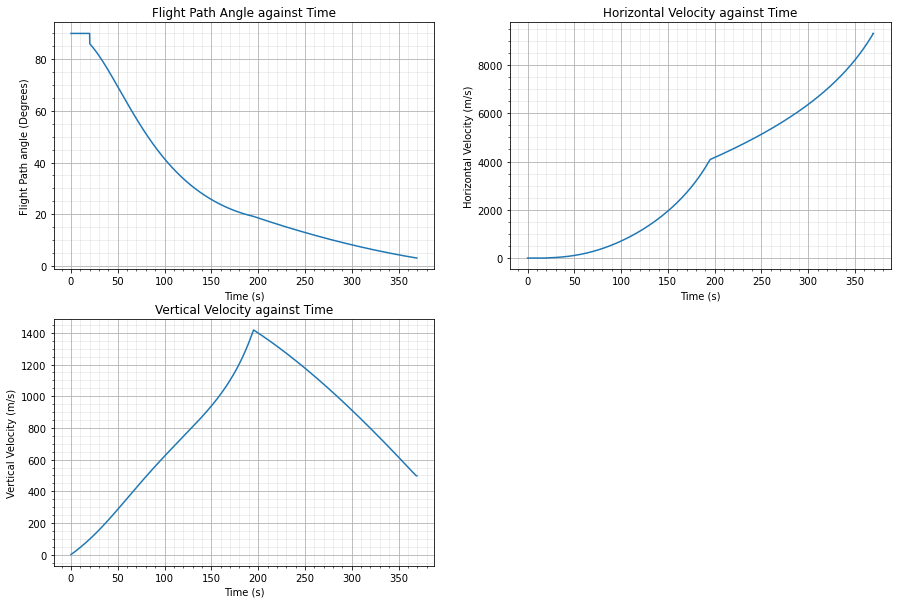

In [103]:
plt.figure(figsize=[15,10])

plt.subplot(221)
plt.plot(time*dt,gamma_deg)
plt.title('Flight Path Angle against Time')
plt.xlabel('Time (s)')
plt.ylabel('Flight Path angle (Degrees)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.subplot(222)
plt.plot(time*dt,velx)
plt.title('Horizontal Velocity against Time')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Velocity (m/s)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.subplot(223)
plt.plot(time*dt,velz)
plt.title('Vertical Velocity against Time')
plt.xlabel('Time (s)')
plt.ylabel('Vertical Velocity (m/s)')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)